In [1]:
import pandas as pd
import numpy as np
import numpy.core.umath_tests
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

E:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
E:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('data/cleaned.csv')

In [4]:
#特征工程 解决编码问题
#User_ID和Product_ID使用序号，Gender和Marray使用二元类型，其他使用热编码
le_U_ID = LabelEncoder()
df['User_ID'] = le_U_ID.fit_transform(df['User_ID'])
le_P_ID = LabelEncoder()
df['Product_ID'] = le_P_ID.fit_transform(df['Product_ID'])
df['Gender'] = np.where(df['Gender']=='M',1,0) # Female: 0, Male: 1
df_Age = pd.get_dummies(df.Age)
df_CC = pd.get_dummies(df.City_Category)
df_SIC = pd.get_dummies(df.Stay_In_Current_City_Years)
df_encoded = pd.concat([df,df_Age,df_CC,df_SIC],axis=1)
df_encoded.drop(['Age','City_Category','Stay_In_Current_City_Years'],axis=1,inplace=True)
print(df_encoded.head(5))

   User_ID  Product_ID  Gender  Occupation  Marital_Status  \
0        0         670       0          10               0   
1        0        2374       0          10               0   
2        0         850       0          10               0   
3        0         826       0          10               0   
4        1        2732       1          16               0   

   Product_Category_1  Product_Category_2  Product_Category_3  Purchase  0-17  \
0                   3                 0.0                 0.0      8370     1   
1                   1                 6.0                14.0     15200     1   
2                  12                 0.0                 0.0      1422     1   
3                  12                14.0                 0.0      1057     1   
4                   8                 0.0                 0.0      7969     0   

  ...  51-55  55+  A  B  C  0  1  2  3  4+  
0 ...      0    0  1  0  0  0  0  1  0   0  
1 ...      0    0  1  0  0  0  0  1  0   0  
2 ...

In [5]:
#考虑所有因素的随机森林
df_frac = df_encoded.sample(frac=0.02,random_state=100)
X = df_frac.drop(['Purchase'], axis=1)
y = df_frac['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Best parameter: {'n_estimators': 300}
Best score: 2952.88


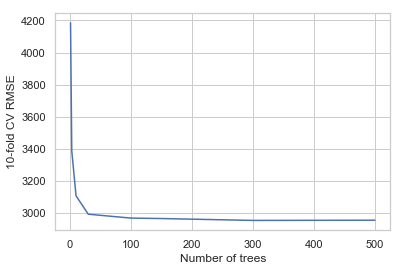

In [6]:
#找最好的树数量
param_grid = {'n_estimators':[1,3,10,30,100,150,300,500]}
grid_rf = GridSearchCV(RandomForestRegressor(),param_grid,cv=10,scoring='neg_mean_squared_error').fit(X_train_scaled,y_train)
plt.figure()
plt.plot(list(param_grid.values())[0],(-1*grid_rf.cv_results_['mean_test_score'])**0.5)
plt.xlabel('Number of trees')
plt.ylabel('10-fold CV RMSE')
print('Best parameter: {}'.format(grid_rf.best_params_))
print('Best score: {:.2f}'.format((-1*grid_rf.best_score_)**0.5))

In [7]:
#调参
param_grid = {'n_estimators':[1,3,10,30,100,150,300,500],'max_depth':[1,3,5,7,9,11]}
grid_rf = GridSearchCV(RandomForestRegressor(),param_grid,cv=10,scoring='neg_mean_squared_error').fit(X_train_scaled,y_train)
'''
plt.figure()
plt.plot(np.array(list(param_grid.values())[0]),np.array((-1*grid_rf.cv_results_['mean_test_score'])**0.5))
plt.xlabel('Number of trees')
plt.ylabel('10-fold CV RMSE')
'''
print(list(param_grid.values())[0])
print((-1*grid_rf.cv_results_['mean_test_score'])**0.5)
print('Best parameter: {}'.format(grid_rf.best_params_))
print('Best score: {:.2f}'.format((-1*grid_rf.best_score_)**0.5))

[1, 3, 10, 30, 100, 150, 300, 500]
[4247.05341258 4247.15943922 4242.77394352 4242.3443541  4241.55523353
 4241.96566505 4242.09576348 4241.71934083 3855.31146603 3722.05578694
 3734.66784735 3691.72723827 3683.29923415 3680.5794297  3689.64911963
 3693.44388342 3389.3974499  3219.04764719 3171.9365182  3182.22730843
 3174.08999789 3172.3412981  3177.07998115 3174.10343071 3132.42601186
 3024.86600664 2969.0861451  2954.44150995 2948.45280251 2946.2521399
 2944.3972186  2945.06369423 3290.58422366 3050.6314955  2985.73445095
 2961.92587993 2947.12595654 2942.12719317 2940.66358406 2939.51864026
 3550.40413782 3176.86622171 3018.93712812 2970.92592281 2949.01301239
 2945.0290755  2943.49453472 2943.85625944]
Best parameter: {'max_depth': 9, 'n_estimators': 500}
Best score: 2939.52


In [8]:
#最好参数：'max_depth': 9, 'n_estimators': 150
train_sizes, train_scores, valid_scores = learning_curve(RandomForestRegressor(max_depth=9, n_estimators=500), X_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')

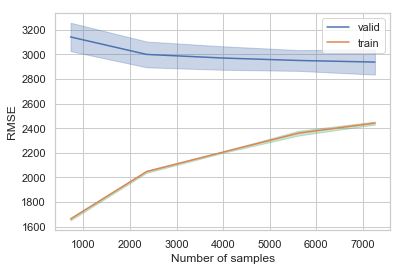

In [9]:
#预测与可视化
train_scores = (-1*train_scores)**0.5
valid_scores = (-1*valid_scores)**0.5
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.plot(train_sizes,valid_scores_mean,label='valid')
plt.plot(train_sizes,train_scores_mean,label='train')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.3,color="g")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,valid_scores_mean + valid_scores_std, alpha=0.3, color="b")
plt.xlabel('Number of samples')
plt.ylabel('RMSE')
plt.legend()

Text(0.5,0,'relative importance')

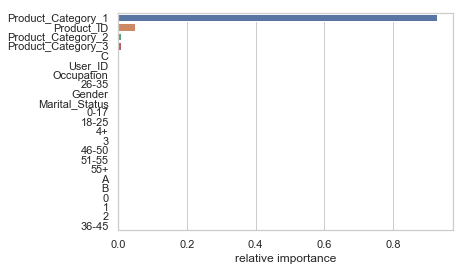

In [12]:
#特征依赖性分析
rf = RandomForestRegressor(max_depth=9, n_estimators=500).fit(X_train_scaled,y_train)
f_im = rf.feature_importances_.round(3)
ser_rank = pd.Series(f_im,index=X.columns).sort_values(ascending=False)

plt.figure()
sns.barplot(y=ser_rank.index,x=ser_rank.values,palette='deep')
plt.xlabel('relative importance')

In [14]:
#上图表示有可能有数据泄露，虽然准确率不错，但应该用其他属性预测
X = df_encoded.drop(['Purchase'], axis=1)
y = df_encoded['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(max_depth=9, n_estimators=500).fit(X_train_scaled,y_train)
y_predicted = rf.predict(X_test_scaled)
print('Test set RMSE: {:.3f}'.format(mean_squared_error(y_test,y_predicted)**0.5))

Test set RMSE: 2840.182


In [15]:
#使用低属性
df_ocup = pd.get_dummies(df.Occupation)
df_encoded = pd.concat([df_encoded,df_ocup],axis=1)
df_encoded.drop(['Occupation'],axis=1,inplace=True)

In [16]:
print(df_encoded)

        User_ID  Product_ID  Gender  Marital_Status  Product_Category_1  \
0             0         670       0               0                   3   
1             0        2374       0               0                   1   
2             0         850       0               0                  12   
3             0         826       0               0                  12   
4             1        2732       1               0                   8   
5             2        1829       1               0                   1   
6             3        1743       1               1                   1   
7             3        3318       1               1                   1   
8             3        3596       1               1                   1   
9             4        2629       1               1                   8   
10            4        2396       1               1                   5   
11            4         140       1               1                   8   
12            4         3

In [17]:
df_frac = df_encoded.sample(frac=0.02,random_state=100)
X = df_frac.drop(['Purchase','User_ID','Product_ID','Product_Category_1','Product_Category_2','Product_Category_3'], axis=1)
y = df_frac['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)

In [18]:
param_grid = {'n_estimators':[1,3,10,30,100,150,300,400,500],'max_depth':[1,3,5,7,9,11]}
grid_rf = GridSearchCV(RandomForestRegressor(),param_grid,cv=10,scoring='neg_mean_squared_error').fit(X_train,y_train)

In [19]:
print('Best parameter: {}'.format(grid_rf.best_params_))
print('Best score: {:.2f}'.format((-1*grid_rf.best_score_)**0.5))

Best parameter: {'max_depth': 5, 'n_estimators': 30}
Best score: 4936.66


In [20]:
train_sizes, train_scores, valid_scores = learning_curve(RandomForestRegressor(max_depth=5, n_estimators=30), X_train, y_train, cv=10, scoring='neg_mean_squared_error')

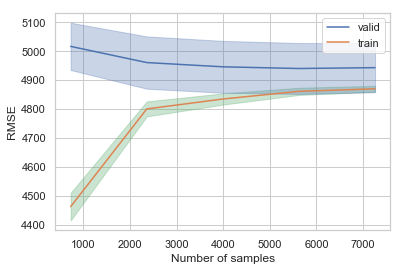

In [21]:
train_scores = (-1*train_scores)**0.5
valid_scores = (-1*valid_scores)**0.5
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.plot(train_sizes,valid_scores_mean,label='valid')
plt.plot(train_sizes,train_scores_mean,label='train')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.3,color="g")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,valid_scores_mean + valid_scores_std, alpha=0.3, color="b")
plt.xlabel('Number of samples')
plt.ylabel('RMSE')
plt.legend()

Text(0.5,0,'relative importance')

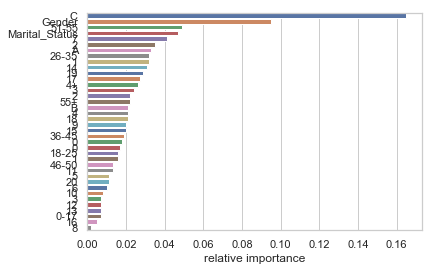

In [22]:
rf = RandomForestRegressor(max_depth=5, n_estimators=30).fit(X_train,y_train)
f_im = rf.feature_importances_.round(3)
ser_rank = pd.Series(f_im,index=X.columns).sort_values(ascending=False)

plt.figure()
sns.barplot(y=ser_rank.index,x=ser_rank.values,palette='deep')
plt.xlabel('relative importance')

In [23]:
y_predicted = rf.predict(X_test)
print('Test set RMSE: {:.3f}'.format(mean_squared_error(y_test,y_predicted)**0.5))

Test set RMSE: 4877.794
